In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

# Show matplotlib plots inline
%matplotlib inline

In [2]:
import os, sys
desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/structural_variants/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/structural_variants/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)
import generate_data as gd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import savemat
import sympy
import random
# MATLAB
# import matlab.engine
# import matlab
# print(matlab.__file__)
# eng = matlab.engine.start_matlab()

Using path =  /Users/jocelynornelasmunoz/Desktop/Research/structural_variants/


# Generate data and save to `.mat` file
1. Define the set of parameters
2. Generate diploid data
3. Save to `.mat` file

In [3]:
params = {
    'r': 1,
    'n': 10**2,
    'k': 10,
    'lambda_c': 4,
    'lambda_p': 4,
    'pctNovel': 0.2,
    'erreps'  : 1e-2,
    'pct_similarity': 0.5}

In [4]:
%%time
data = gd.generate_diploid_data(params, seed=10)
savemat((desktop_path + 'data/dip_%ipctNovel_%ik_%in.mat')%(int(params['pctNovel']*100),params['k'],params['n']) , data)

Using seed 10 
Generating data...
Done!

Using parameters:
	 r :  1
	 n :  100
	 k :  10
	 lambda_c :  4
	 lambda_p :  4
	 pctNovel :  0.2
	 erreps :  0.01
	 pct_similarity :  0.5
CPU times: user 11.2 ms, sys: 4.68 ms, total: 15.9 ms
Wall time: 14.6 ms


In [10]:
%%time
data = gd.generate_haploid_data(params, seed=1)

2
12
Done!

Using parameters:
	 r :  1
	 n :  100
	 k :  10
	 lambda_c :  4
	 lambda_p :  4
	 pctNovel :  0.2
	 erreps :  0.01
	 pct_similarity :  0.5
	 q :  [ 99  32  40  22  34  92  91  35   6  55   3  96  68  16  69  11  54  30
  45  77  60  74  78  72  62  70  51  33   7  86  38 100  58  76  81  89
  42  28  17  41  47  98  80  14  46  56  63  93   8  67  84  90  97  83
  59  79   5  48  53  29  21  25  52  37  64  31  49  27  61  88  50  87
  26  43  94  19  44  15  73   1  36  82  71  23  65   2   4  18  85  75
  24  95  39  13   9  66  20  57  10  12]
CPU times: user 2.8 ms, sys: 1.99 ms, total: 4.79 ms
Wall time: 4.87 ms


In [11]:
kind = 'haploid'
outpath = (path + 'data/%s_%ipctNovel_%ik_%in_reproducedAPL.mat')%(kind,int(params['pctNovel']*100),params['k'],params['n'])
savemat(outpath, data)
print(outpath)

/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/structural_variants/data/haploid_20pctNovel_10k_100n_reproducedAPL.mat


## Analysis of data

In [22]:
# Shows what variables will be saved
data.keys()

dict_keys(['f_p', 'f_h', 'f_n', 'f_c', 'A_p', 'mu_p', 'var_p', 's_p', 'A_c', 'mu_c', 'var_c', 's_c', 'r', 'n', 'k', 'lambda_c', 'lambda_p', 'pctNovel', 'erreps', 'pct_similarity', 'q'])

In [19]:
print('Nonzero counts for vector signals')

print('f_p: ',np.count_nonzero(data['f_p']))
print('f_c: ',np.count_nonzero(data['f_c']))
print('f_h: ',np.count_nonzero(data['f_h']))
print('f_n: ',np.count_nonzero(data['f_n']))

Nonzero counts for vector signals
f_p:  10
f_c:  10
f_h:  8
f_n:  2


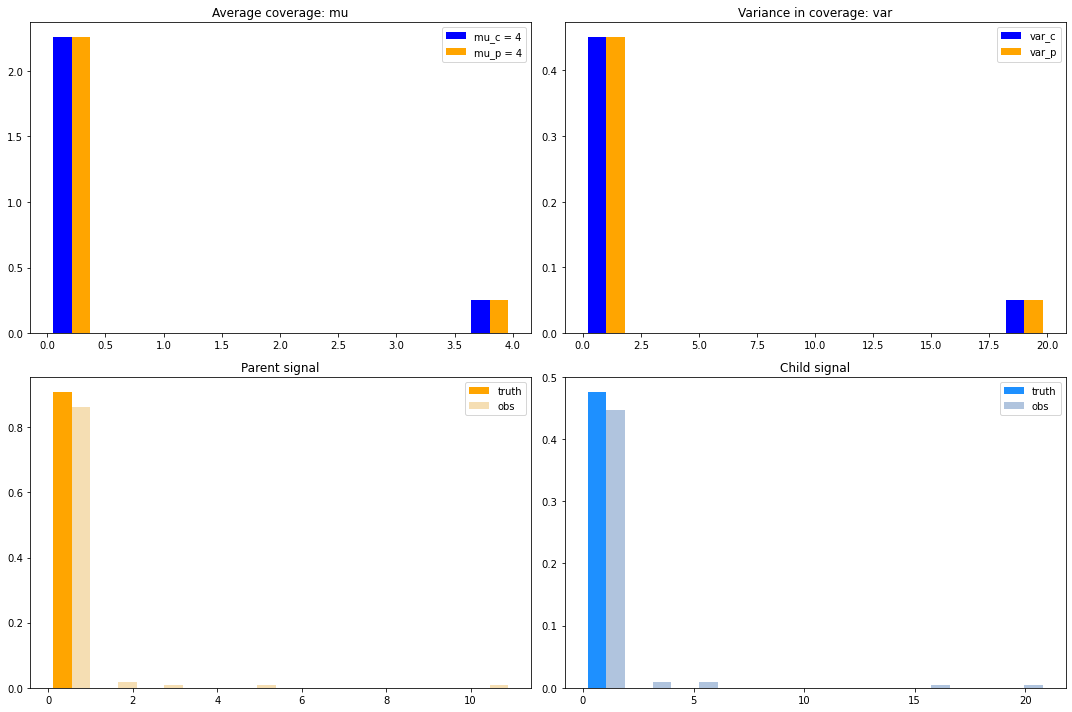

In [6]:
# Plot histograms of mean and variance of TRUE data
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
stacked_mu  = np.reshape(np.stack((data['mu_c'], data['mu_p']), axis=1), (data['mu_c'].shape[0],2))
stacked_var = np.reshape(np.stack((data['var_c'], data['var_p']), axis=1), (data['var_c'].shape[0],2))
stacked_p = np.reshape(np.stack((data['f_p'], data['s_p']), axis=1), (data['f_p'].shape[0],2))
stacked_c = np.reshape(np.stack((data['f_c'], data['s_c']), axis=1), (data['f_c'].shape[0],2))

colors = ['blue', 'orange']
ax0.hist(stacked_mu, 10, density=True, histtype='bar', color=colors, label=['mu_c = %s'%str(4), 'mu_p = %s'%str(4)])
ax0.legend(prop={'size': 10})
ax0.set_title('Average coverage: mu')
#ax0.set_xlim([0, 5]); ax0.set_ylim([0, 2.5])

ax1.hist(stacked_var, 10, density=True, histtype='bar', color=colors, label=['var_c', 'var_p'])
ax1.legend(prop={'size': 10})
ax1.set_title('Variance in coverage: var')
#ax1.set_xlim([0, 5]); ax1.set_ylim([0, 2.5])

ax2.hist(stacked_p, 10, density=True, histtype='bar', color=['orange','wheat'], label=['truth', 'obs'])
ax2.legend(prop={'size': 10})
ax2.set_title('Parent signal')

ax3.hist(stacked_c, 10, density=True, histtype='bar', color=['dodgerblue','lightsteelblue'], label=['truth', 'obs'])
ax3.legend(prop={'size': 10})
ax3.set_title('Child signal')

fig.set_size_inches(15, 10)
fig.tight_layout()
plt.show()

In [8]:
np.unique(data['s_p'])

array([0, 3, 5, 6, 7])

In [10]:
np.count_nonzero(np.random.negative_binomial(data['mu_c']**2/(data['var_c']-data['mu_c']),data['mu_c']/data['var_c']))

9

In [11]:
(data['mu_c']**2/(data['var_c']-data['mu_c'])).transpose()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

In [12]:
(data['mu_c']/data['var_c']).transpose()

array([[0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.2       , 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.2       , 0.99009901,
        0.99009901, 0.2       , 0.99009901, 0.99009901, 0.2       ,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901,
        0.2       , 0.99009901, 0.99009901, 0.99009901, 0.2       ,
        0.99009901, 0.99009901, 0.99009901, 0.99

In [13]:
data['f_c'].transpose()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0.]])

In [14]:
data['s_c'].transpose()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 15,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 14,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0]])

(array([37., 32., 22.,  0.,  7.,  1.,  0.,  0.,  0.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

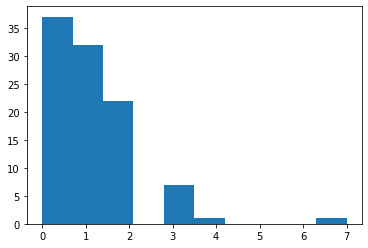

In [23]:
plt.hist(data['s_c'])

(array([48.,  0., 31.,  0., 12.,  0.,  6.,  0.,  1.,  2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

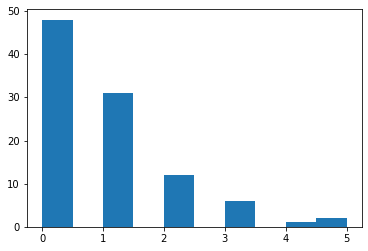

In [10]:
plt.hist(data['s_p'])

In [19]:
# visualize sparse matrix
data['A_yc'].toarray()

KeyError: 'A_yc'

# Debug `generate_diploid_data`

In [ ]:
prnt=True
# First, we randomly permute a sequence (1,2,3,...n)
q = np.random.permutation(np.arange(1,params['n']+1))


startVal = int(params['k']*params['pctNovel']); #print(startVal)
endVal = int(startVal +params['k']) ; #print(endVal)
similarity = int(params['pct_similarity']* params['k']) # pct_similarity * number of SVs


# Create signal variables and initialize signal vectors with all zeros
signals = ['f_p2', 'f_c']
for i,letter in enumerate(['p', 'h', 'n']):
    signals.append('f_%s'%letter)
    signals.append('z_%s'%letter)
    signals.append('y_%s'%letter)

d= {}
for signal in signals: d[signal] = np.zeros((params['n'],1), dtype=np.int32)
if prnt: print('Signals initialized: ', [key for key in d.keys()])

# Parent signals: 
#        f_p  - k elements will be 1s and 2s randomly selected
#        f_p2 - floor of %similarity*k elements will be the same as f_p and the rest will be random 1s and 2s
#               (i.e. the parents will only share a given percentage of SV's)

# Insert k number of 1's and 2's in the first parent
for i in q[:params['k']]: d['f_p'][i] = np.random.randint(1,3) 

# parent 2 shares similarity number of SV's with parent 1, 
# q[0:similarity] is the positions for which both parents will share SV's
# the remaining k - similarity positions will be chosen randomly as to not overlap with existing SVs
rand_choices = np.random.choice(np.setdiff1d(q, q[0:similarity]), size=params['k'] -similarity, replace= False); #rand_choices.sort(); q[0:similarity].sort()
d['f_p2'][q[0:similarity]] = d['f_p'][q[0:similarity]]
d['f_p2'][rand_choices]= np.random.randint(1,3) 

# verify that both parents have the same amount of nonzero entries
if np.count_nonzero(d['f_p2']) != np.count_nonzero(d['f_p']): 
    print('PARENTS DO NOT HAVE EQUAL AMOUNT OF NONZERO ENTRIES !!')
    print('f_p: {} \nf_p2: {}'.format(np.count_nonzero(d['f_p']),np.count_nonzero(d['f_p2'])))


# Child signal
#     First, we defined the inherited SVs through a logical implementation 
#     of inheritance using parent 1 (f_p) and parent 2 (f_p2)
for i in np.arange(d['f_p'].shape[0]):
    if   (d['f_p'][i]==2 and d['f_p2'][i]==2): d['f_h'][i]= 2
    elif (d['f_p'][i]==1 and d['f_p2'][i]==1): d['f_h'][i]= np.random.randint(0,3)
    elif (d['f_p'][i]==2 and d['f_p2'][i]==0) or (d['f_p'][i]==0 and d['f_p2'][i]==2): d['f_h'][i]= 1
    elif (d['f_p'][i]==2 and d['f_p2'][i]==1) or (d['f_p'][i]==1 and d['f_p2'][i]==2): d['f_h'][i]= np.random.randint(1,3)
    elif (d['f_p'][i]==1 and d['f_p2'][i]==0) or (d['f_p'][i]==0 and d['f_p2'][i]==1): d['f_h'][i]= np.random.randint(0,2)

#    Next, we define the novel SVs 
#    define inherited indices and novel indices, make sure they do not overlap
inherited_pos = d['f_h'].nonzero()[0]; inherited_pos.sort()
novel_pos = np.random.choice(np.setdiff1d(q, inherited_pos), size=int(params['k'] *params['pctNovel']), replace= False)
d['f_n'][novel_pos]= np.random.randint(1,3) 

#    Lastly, we define the complete child signal
d['f_c'] = d['f_h'] + d['f_n']

In [ ]:
# positions for which both parents will share SV's
q[0:similarity]

In [ ]:
# parent 2 shares similarity number of SV's with parent 1
#d['f_p2'][q[0:similarity]] = d['f_p'][q[0:similarity]]
#d['f_p2'][q[0:similarity]]
d['f_p2'].transpose()

In [ ]:
rand_choices = np.random.choice(q, size=params['k'] -similarity, replace= False)
rand_choices.sort()
print(rand_choices)

In [ ]:
(q[0:similarity]).sort()
q[0:similarity]

In [ ]:
q[0:similarity] == rand_choices

In [ ]:
(q[0:similarity]).sort()

In [ ]:
for i in q[0:similarity]:
    print(i)

In [ ]:
for i, j in enumerate(q[0:similarity]): print(i,j)

In [ ]:
# trying to make sure similarity positions are not overwritten in parent 2
# 
for i, val in enumerate(q[0:similarity]): 
    if val not in rand_choices:
        pass 
        print('good: ', val)
    else: 
        rand_choices[i] = np.random.choice(q) 
        print('position now: ', rand_choices[i])

In [ ]:
d['f_p2'][rand_choices]= np.random.randint(1,3) 
d['f_p2'][rand_choices]

In [ ]:
d['f_p'][rand_choices]

In [ ]:
#np.count_nonzero(d['f_p2']) 
np.count_nonzero(d['f_c'])

In [ ]:
if np.count_nonzero(d['f_p2']) != np.count_nonzero(d['f_p']): 
    print('PARENTS DO NOT HAVE EQUAL AMOUNT OF NONZERO ENTRIES !!')
    print('f_p: {} \nf_p2: {}'.format(np.count_nonzero(d['f_p']),np.count_nonzero(d['f_p2'])))

In [ ]:
for i in np.arange(d['f_p'].shape[0]):
    if   (d['f_p'][i]==2 and d['f_p2'][i]==2): d['f_h'][i]= 2
    elif (d['f_p'][i]==1 and d['f_p2'][i]==1): d['f_h'][i]= np.random.randint(0,3)
    elif (d['f_p'][i]==2 and d['f_p2'][i]==0) or (d['f_p'][i]==0 and d['f_p2'][i]==2): d['f_h'][i]= 1
    elif (d['f_p'][i]==2 and d['f_p2'][i]==1) or (d['f_p'][i]==1 and d['f_p2'][i]==2): d['f_h'][i]= np.random.randint(1,3)
    elif (d['f_p'][i]==1 and d['f_p2'][i]==0) or (d['f_p'][i]==0 and d['f_p2'][i]==1): d['f_h'][i]= np.random.randint(0,2)
d['f_h'].transpose()

In [ ]:
inherited_pos = d['f_h'].nonzero()[0]; inherited_pos.sort()
inherited_pos

In [ ]:
novel_pos = np.random.choice(q, size=int(params['k'] *params['pctNovel']), replace= False); novel_pos.sort()
novel_pos

In [ ]:
inherited_pos[np.where(inherited_pos == 27)[0]] = np.random.choice(q)
inherited_pos

In [ ]:
novel_pos = np.array([15,17])

In [ ]:
for i, val in enumerate(novel_pos):
    if val not in inherited_pos:
        pass 
        print(val, ' from novel not in inherited')
    else: 
        novel_pos[i] = np.random.choice(q)
        #inherited_pos[np.where(inherited_pos == val)[0]] = np.random.choice(q)
        print('not good')

In [ ]:
np.count_nonzero(d['f_c'])

# Defining generate data functions

In [ ]:
def generate_haploid_data(params):
    '''
    Generate simulated data for a one parent, one child Structural Variant analysis
    Args: A dictionary containing the following parameters as keys
        n: size of data vectors (signals)
        k: total number of structural variants
        pctNovel: percent of novel structural variants in [0,1] (biological reality- very small %)
        lambda_p, lambda_c: sequence coverage of child and parent, respectively
        erreps: error (>0) incurred by sequencing and mapping process
        r: dispersion parameter for Negative Binomial distribution
    
    Output: A dictionary containing the following data elements as keys
        A_c: (lambda_c - erreps) I_n, sparse diagonal nxn matrix. I_n is nxn identity matrix
        A_p: (lambda_p - erreps) I_n, sparse diagonal nxn matrix. I_n is nxn identity matrix
        mu_p, var_p: Mean and variance sequence coverage for parent; mu_p = A_p * f_p 
        mu_c, var_c: Mean and variance sequence coverage for child;  mu_c = A_c * f_c 
        s_p: nx1 random vector drawn from Negative binomial distribution (for parent)
        s_c: nx1 random vector drawn from Negative binomial distribution (for child)
        TODO: add mu and var
        for i in {P (parent), H (inherited), N (novel)}:
        z_i: nx1 indicator vector of homogeneous structural variants
        y_i: nx1 indicator vector of heterogeneous structural variants
        
    '''
    q = np.random.permutation(params['n'])
    #print(q)
    startVal = int(params['k']*params['pctNovel']); #print(startVal)
    endVal = int(startVal +params['k']) ; #print(endVal)

    f_p, f_c, f_h, f_n = np.zeros((params['n'],1), dtype=np.int8),np.zeros((params['n'],1), dtype=np.int8), np.zeros((params['n'],1), dtype=np.int8), np.zeros((params['n'],1), dtype=np.int8)
    f_p[q[: params['k']]], f_c[q[startVal:endVal]] = 1,1
    f_h[q[startVal:params['k']+1]], f_n[q[params['k']+1:endVal]] = 1,1
    
    
    d = {}
    d['f_p'] = f_p; d['f_h'] = f_h; d['f_n'] = f_n; d['f_c'] = f_h + f_n; 
    
    for i, letter in enumerate(['p','c']):
        d['A_%s'%letter]   = (params["lambda_%s"%letter] - params['erreps'])*sparse.eye(params['n'])
        d['mu_%s'%letter]  = np.matmul(d['A_%s'%letter].toarray(), d['f_%s'%letter]) + params['erreps']
        d['var_%s'%letter] = d['mu_%s'%letter] +(1/params['r'])*(d['mu_%s'%letter]**2)
        d['s_%s'%letter]   = np.random.negative_binomial(d['mu_%s'%letter]/(d['var_%s'%letter]-d['mu_%s'%letter]),d['mu_%s'%letter]/d['var_%s'%letter])
    
    
    return d

In [ ]:
params = {
    'r': 1,
    'n': 10**2,
    'k': 10,
    'lambda_c': 4,
    'lambda_p': 8,
    'pctNovel': 0.15,
    'erreps'  : 1e-2,
    #'suffix'  : ['p','c'],
    'pct_similarity': 0.6}

In [ ]:
def generate_diploid_data(params):
    q = np.random.permutation(params['n'])
    startVal = int(params['k']*params['pctNovel']); #print(startVal)
    endVal = int(startVal +params['k']) ; #print(endVal)
    similarity = int(params['pct_similarity']* params['k']) # pct_similarity * number of SVs

    signals = ['f_p2', 'f_c']
    for i,letter in enumerate(['p', 'h', 'n']):
        signals.append('f_%s'%letter)
        signals.append('z_%s'%letter)
        signals.append('y_%s'%letter)

    # Initialize signals
    d= {}
    for signal in signals: d[signal] = np.zeros((params['n'],1), dtype=np.int32)

    # parent signals: 
    #        f_p  - k elements will be 1s and 2s randomly selected
    #        f_p2 - floor of %similarity*k elements will be the same as f_p and the rest will be random 1s and 2s
    for i in q[:params['k']]: d['f_p'][i] = np.random.randint(1,3) 
    d['f_p2'][q[0:similarity]] = d['f_p'][q[0:similarity]]
    d['f_p2'][random.choices(q, k=params['k'] -similarity)]= np.random.randint(1,3) 

    # child signal
    #     inherited
    for i in np.arange(d['f_p'].shape[0]):
        if   (d['f_p'][i]==2 and d['f_p2'][i]==2): d['f_c'][i]= 2
        elif (d['f_p'][i]==1 and d['f_p2'][i]==1): d['f_c'][i]= np.random.randint(0,3)
        elif (d['f_p'][i]==2 and d['f_p2'][i]==0) or (d['f_p'][i]==0 and d['f_p2'][i]==2): d['f_c'][i]= 1
        elif (d['f_p'][i]==2 and d['f_p2'][i]==1) or (d['f_p'][i]==1 and d['f_p2'][i]==2): d['f_c'][i]= np.random.randint(1,3)
        elif (d['f_p'][i]==1 and d['f_p2'][i]==0) or (d['f_p'][i]==0 and d['f_p2'][i]==1): d['f_c'][i]= np.random.randint(0,2)
        
    #     novel        
    d['f_n'][random.choices(q, k=params['k'] -similarity)]= np.random.randint(1,3) 
    d['f_c'] = d['f_h'] +d ['f_n']
    
    # convert signals to indicators
    for j,letter in enumerate(['p','h','n']):
        for i in np.arange(d['f_c'].shape[0]):
            if   d['f_%s'%letter][i]==2: d['z_%s'%letter][i]=1
            elif d['f_%s'%letter][i]==1: d['y_%s'%letter][i]=1
            
    for i, letter in enumerate(['p','c']):
        d['A_%s'%letter]   = (params['lambda_%s'%letter] - params['erreps'])*sparse.eye(params['n'])
        d['mu_%s'%letter]  = np.matmul(d['A_%s'%letter].toarray(), d['f_%s'%letter]) + params['erreps']
        d['var_%s'%letter] = d['mu_%s'%letter] +(1/params['r'])*(d['mu_%s'%letter]**2)
        d['s_%s'%letter]   = np.random.negative_binomial(d['mu_%s'%letter]/(d['var_%s'%letter]-d['mu_%s'%letter]),d['mu_%s'%letter]/d['var_%s'%letter])
        
    return d

In [ ]:
hap = generate_haploid_data(params)

In [ ]:
hap.keys()

In [ ]:
for j,letter in enumerate(['p','h','n']):
    print('f_%s: \n'%letter,np.transpose(d['f_%s'%letter]))
    print('z_%s: \n'%letter,np.transpose(d['z_%s'%letter]))
    print('y_%s: \n'%letter,np.transpose(d['y_%s'%letter]))

In [ ]:
data1 = generate_diploid_data(params)

In [ ]:
data1.keys()

In [ ]:
np.transpose(data1['f_p'])

In [ ]:
np.transpose(data1['s_p'])

In [ ]:
np.transpose(data1['f_p'] - data1['s_p'])